In [6]:
import qiskit
from qiskit import quantum_info
from qiskit.execute_function import execute
from qiskit import BasicAer
import numpy as np
import pickle
import json
import os
from collections import Counter
from sklearn.metrics import mean_squared_error
from typing import Dict, List
import matplotlib.pyplot as plt
import math

# Utility functions (given to us)

def simulate(circuit: qiskit.QuantumCircuit) -> dict:
    """Simulate the circuit, give the state vector as the result."""
    backend = BasicAer.get_backend('statevector_simulator')
    job = execute(circuit, backend)
    result = job.result()
    state_vector = result.get_statevector()
    histogram = dict()
    for i in range(len(state_vector)):
        population = abs(state_vector[i]) ** 2
        if population > 1e-9:
            histogram[i] = population
    
    return histogram


def histogram_to_category(histogram):
    """This function take a histogram representations of circuit execution results, and process into labels as described in 
    the problem description."""
    assert abs(sum(histogram.values())-1)<1e-8
    positive=0
    for key in histogram.keys():
        digits = bin(int(key))[2:].zfill(20)
        if digits[-1]=='0':
            positive+=histogram[key]
        
    return positive


def count_gates(circuit: qiskit.QuantumCircuit) -> Dict[int, int]:
    """Returns the number of gate operations with each number of qubits."""
    counter = Counter([len(gate[1]) for gate in circuit.data])
    #feel free to comment out the following two lines. But make sure you don't have k-qubit gates in your circuit
    #for k>2
    # for i in range(2,20):
    #     assert counter[i]==0
        
    return counter


def image_mse(image1,image2):
    # Using sklearns mean squared error:
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html
    return mean_squared_error(image1, image2)

In [7]:
# #load the mock data (for testing only)
# files=os.listdir("mock_data")
# dataset=list()
# for file in files:
#     with open('mock_data/'+file, "r") as infile:
#         loaded = json.load(infile)
#         dataset.append(loaded)

# Irrelevant data

[0.         0.         0.         0.         0.         0.
 0.         0.         0.00059977 0.00138408 0.00207612 0.00307574
 0.00202999 0.00092272 0.00098424 0.00127643 0.0028143  0.00299885
 0.00149173 0.00044598 0.         0.         0.         0.
 0.         0.         0.         0.        ]
T-shirt?:  False


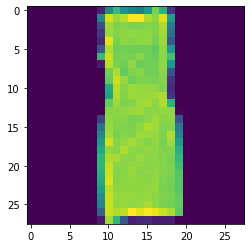

In [8]:
# Load Fashion-MNIST data (only t-shirts, label=0)
images = np.load('data/images.npy')
labels = np.load('data/labels.npy')

# Visualizing the dataset
print(images[0][0])
plt.imshow(images[1100])
print('T-shirt?: ', labels[1100])

In [9]:
def encode(image):
    print("Encoding...")
    number_of_qubits = math.ceil(math.log(28*28, 2))
    amplitude_vector = [0] * (2**number_of_qubits)
    sum_squares = 0
    amplitude_counter = 0
    for i in image:
        for j in i:
            sum_squares+=j**2
            amplitude_vector[amplitude_counter] = j
            amplitude_counter+=1
    global norm
    norm = 1/np.sqrt(sum_squares)
    amplitude_vector_new = [i*norm for i in amplitude_vector]
    
    # Some previous tests we were running -- ignore
    
    # global imtest
    # imtest=[[0]*28 for z in range(28)]
    # a_counter=0
    # for i in range(28):
    #     for j in range(28):
    #         imtest[i][j]=amplitude_vector[a_counter]#/norm
    #         a_counter+=1
            
            
    # print(amplitude_vector)
    qr = qiskit.QuantumRegister(number_of_qubits)
    qc = qiskit.QuantumCircuit(qr)
    qc.initialize(amplitude_vector_new, qr)
    # qc.draw
    print("Encoded!")
    return qc

def decode(histogram):
    print("Decoding...")      
    image = [[0] * 28 for z in range(28)]
    amplitude_counter=1
    for i in range(28):
        for j in range(28):
            image[i][j] = histogram.get(amplitude_counter, 0)#/norm
            amplitude_counter+=1
    print("Decoded!")
    return image

def run_part1(image):
    #encode image into a circuit
    circuit = encode(image)

    #simulate circuit
    histogram = simulate(circuit)

    #reconstruct the image
    image_re = decode(histogram)

    return circuit, image_re

Encoding...
Encoded!


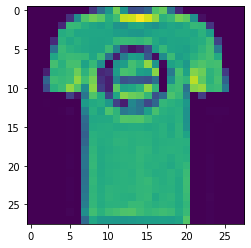

In [10]:
test_image = images[0]
plt.imshow(test_image)

encoded = encode(test_image)

Decoding...
Decoded!
6.190224439177201e-07


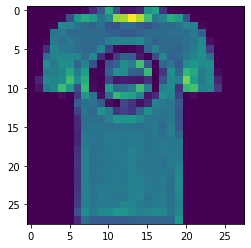

In [11]:
decoded =  decode(simulate(encoded))
print(image_mse(images[0], decoded))
plt.imshow(decoded)

In [ ]:
# Submission grade

n = 1 # for one image
mse = 0
gatecount = 0
test_image = images[0] # same image that is shown above


    
#encode image into circuit
circuit, image_re = run_part1(test_image)

#count the number of qubit gates used
gatecount += count_gates(circuit)[2]

# calculate mean square error
mse += image_mse(test_image, image_re)
    
#fidelity of reconstruction
fidelity = 1 - mse
gatecount = gatecount / n
print('gatecount', gatecount)
print('fidelity' , fidelity)

#score for part1 
print(fidelity * (0.999 ** gatecount))

Encoding...
Encoded!
